In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_013.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-22.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F10-43.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F66-12.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_193.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/10_00_063.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F5-2.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_133.p

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Activation, Reshape
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import tensorflow_addons as tfa
import os
import numpy as np 
import pandas as pd 

import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Text(0.5, 1.0, 'Segmentation')

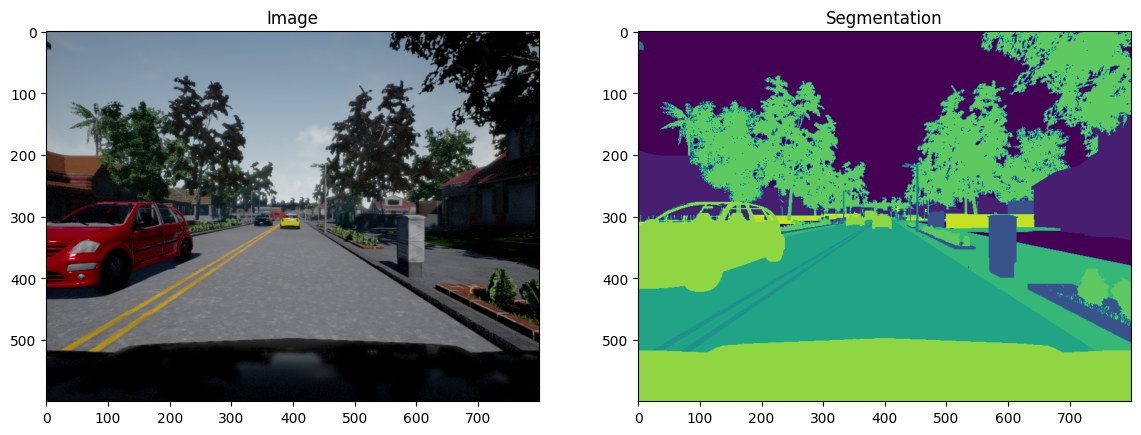

In [17]:
image_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/')
mask_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/')
test_path = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/')
test_mask = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img = imageio.imread(image_list[120])
mask = imageio.imread(mask_list[120])
    

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [18]:
len(test_mask_list)

1000

In [19]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [20]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

**SEGNET**

In [21]:
def single_conv(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [22]:
def double_conv(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [23]:
def triple_conv(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [24]:
pool_size=(2, 2)
def Segnet_Model():



  inputs = layers.Input(shape=(128,128,3))

  # encoder

  l1 = double_conv(inputs,64)
  pool_1, mask_1 = tf.nn.max_pool_with_argmax(l1, 3, 2, padding="SAME")


  l2 = double_conv(pool_1,128)
  pool_2, mask_2 = tf.nn.max_pool_with_argmax(l2, 3, 2, padding="SAME")

  l3 = triple_conv(pool_2,256)
  pool_3, mask_3 = tf.nn.max_pool_with_argmax(l3, 3, 2, padding="SAME")

  l4 = triple_conv(pool_3,512)
  pool_4, mask_4 = tf.nn.max_pool_with_argmax(l4, 3, 2, padding="SAME")

  l5 = triple_conv(pool_4,512)
  pool_5, mask_5 = tf.nn.max_pool_with_argmax(l5, 3, 2, padding="SAME")

  # decoder

  unpool_1 = tfa.layers.MaxUnpooling2D(pool_size)(pool_5, mask_5)
  l_1 = triple_conv(unpool_1,512)

  unpool_2 = tfa.layers.MaxUnpooling2D(pool_size)(l_1, mask_4)
  l_2 = double_conv(unpool_2,512)
  l_2 = single_conv(l_2,256)
  

  unpool_3 = tfa.layers.MaxUnpooling2D(pool_size)(l_2, mask_3)
  l_3 = double_conv(unpool_3,256)
  l_3 = single_conv(l_3,128)

  unpool_4 = tfa.layers.MaxUnpooling2D(pool_size)(l_3, mask_2)
  l_4 = single_conv(unpool_4,128)
  l_4 = single_conv(l_4,64)

  unpool_5 = tfa.layers.MaxUnpooling2D(pool_size)(l_4, mask_1)
  l_5 = single_conv(unpool_5,64)

  output = layers.Conv2D(23, 1, padding="same", activation = "softmax")(l_5)

  segnet_model = tf.keras.Model(inputs, output, name="Seg-Net")

  return segnet_model


segnet_model = Segnet_Model()
segnet_model.summary()

Model: "Seg-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 128, 128, 64  256        ['conv2d_26[0][0]']              
 ormalization)                  )                                                           

In [25]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [26]:
segnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [27]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) #try , cmap='Paired'
        plt.axis('off')
    plt.show()

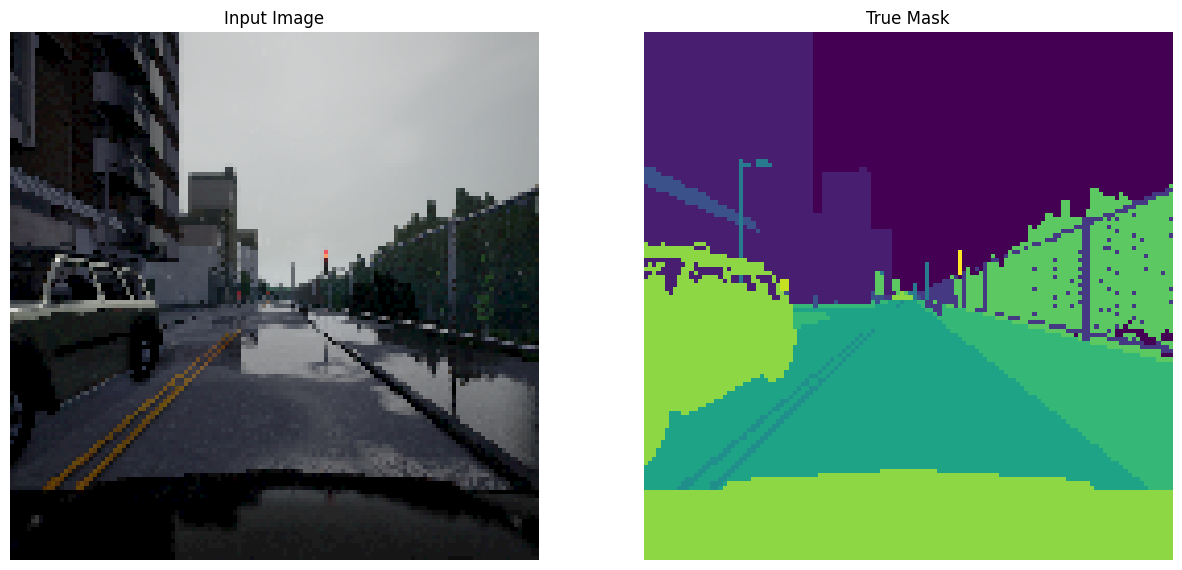

In [28]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [29]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = segnet_model.fit(train_dataset,validation_data=tests_dataset, epochs=EPOCHS)

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/50
32/32 [==============================] - 91s 2s/step - loss: 2.1876 - updated_mean_io_u_1: 0.0606 - accuracy: 0.4188 - val_loss: 73.4606 - val_updated_mean_io_u_1: 0.0391 - val_accuracy: 0.3447
Epoch 2/50
32/32 [==============================] - 41s 1s/step - loss: 0.7722 - updated_mean_io_u_1: 0.1972 - accuracy: 0.7978 - val_loss: 2.7767 - val_updated_mean_io_u_1: 0.0618 - val_accuracy: 0.2975
Epoch 3/50
32/32 [==============================] - 42s 1s/step - loss: 0.5384 - updated_mean_io_u_1: 0.3366 - accuracy: 0.8548 - val_loss: 3.2595 - val_updated_mean_io_u_1: 0.0476 - val_accuracy: 0.2682
Epoch 4/50
32/32 [==============================] - 44s 1s/step - loss: 0.4514 - updated_mean_io_u_1: 0.3645 - accuracy: 0.8733 - val_loss: 1.8219 - val_updated_mean_io_u_1: 0.1347 - val_accuracy: 0.5593
Epoch 5/50
32/32 [==============================] - 45s 1s/s

In [30]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = segnet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(segnet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 5s 5s/step


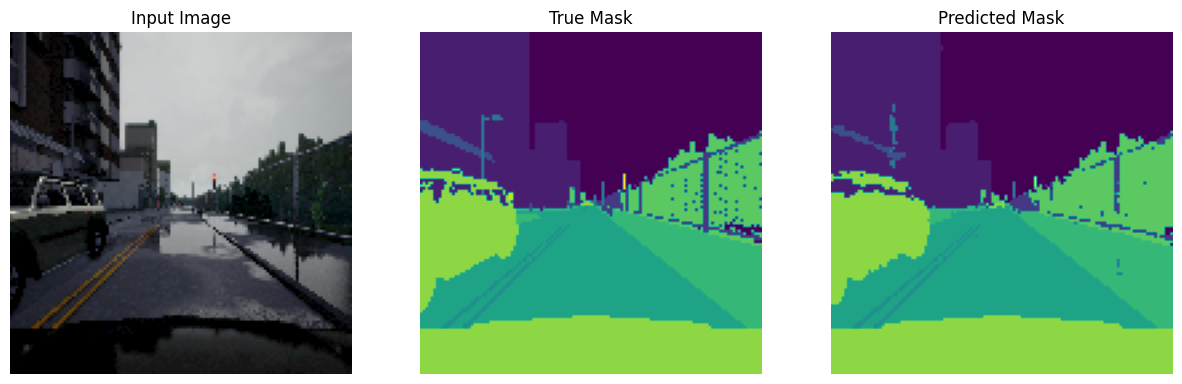

1/1 [==============================] - 1s 515ms/step


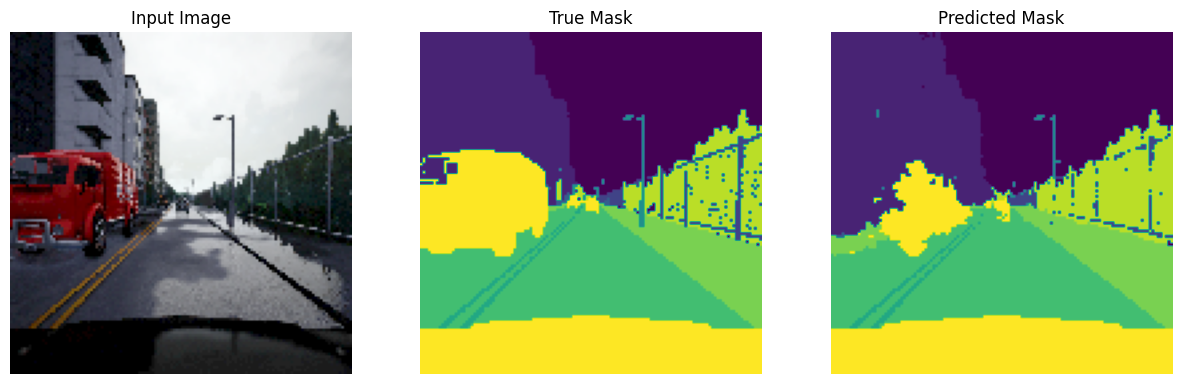

1/1 [==============================] - 0s 456ms/step


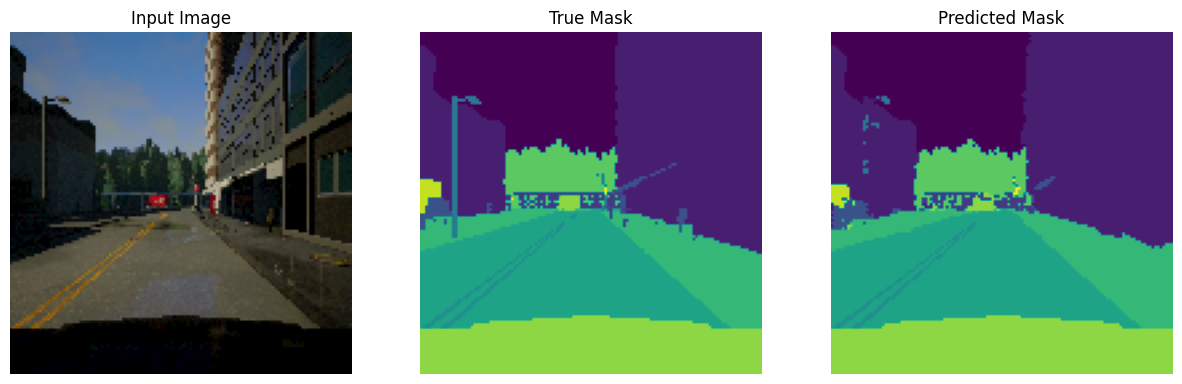

1/1 [==============================] - 0s 446ms/step


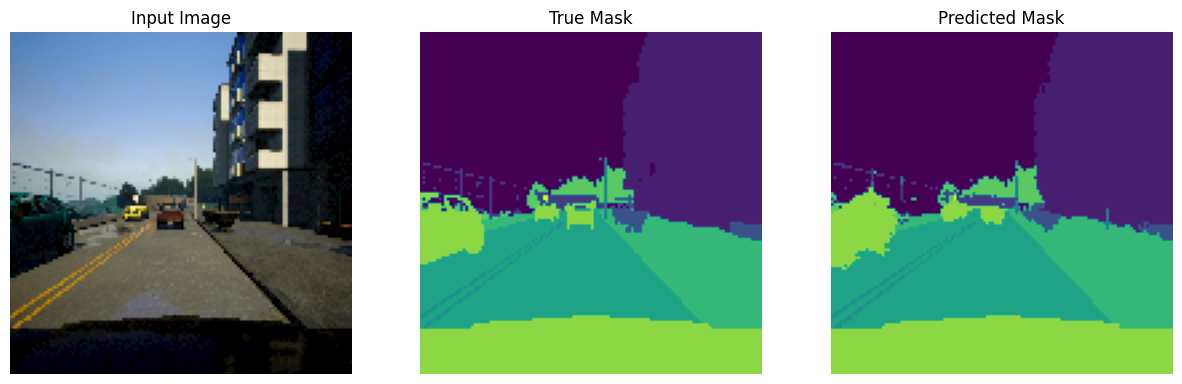

1/1 [==============================] - 0s 442ms/step


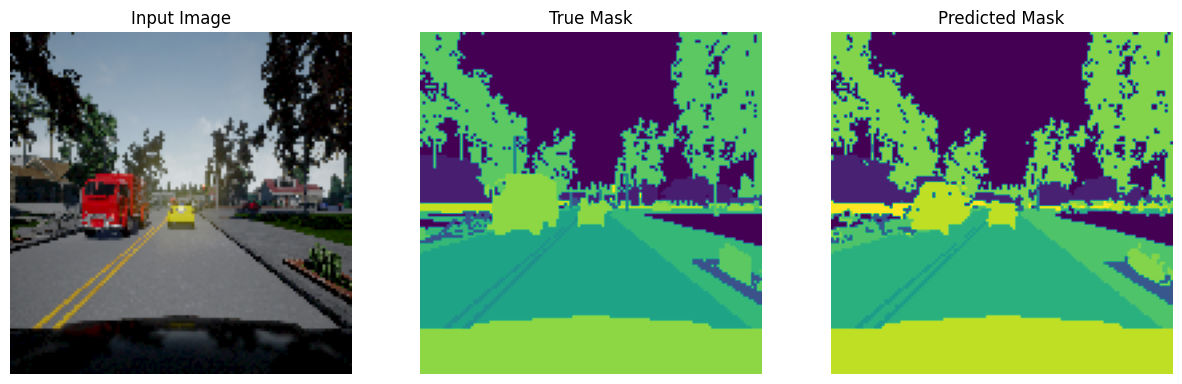

In [31]:
show_predictions(tests_dataset, 5)